In [107]:
from itertools import islice

import math
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score
import csv 
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.preprocessing import text, sequence
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras import backend as K

from tensorflow.keras.layers import Input, Embedding, Bidirectional, Dense, LSTM, TimeDistributed, Lambda, SpatialDropout1D

from tensorflow.keras.models import Model
from keras.optimizers import SGD, Adam, RMSprop

In [2]:
train_data = pd.read_csv("../input/thesis-clean-data/train.csv") 
test_data = pd.read_csv("../input/thesis-clean-data/test.csv")
val_data = pd.read_csv("../input/thesis-clean-data/val.csv")

In [3]:
train_data.head()

,Full Text,UMLS Text,Original Text,Entity Codes,Entities
0,DCTN4 as a modifier of chronic Pseudomonas aer...,"['C4308010', 'as', 'a', 'modifier', 'of', 'C08...","['DCTN4', 'as', 'a', 'modifier', 'of', 'chroni...","['T116', 'o', 'o', 'o', 'o', 'T047', 'o', 'T04...","['Amino Acid, Peptide, or Protein', 'o', 'o', ..."
1,Prevascularized silicon membranes for the enha...,"['C0042382', 'C0037114', 'C1706182', 'for', 't...","['Prevascularized', 'silicon', 'membranes', 'f...","['T169', 'T109', 'T073', 'o', 'o', 'T052', 'o'...","['Functional Concept', 'Organic Chemical', 'Ma..."
2,Seated maximum flexion: An alternative to stan...,"['C0277814', 'C0806909', 'C0231452', ':', 'An'...","['Seated', 'maximum', 'flexion', ':', 'An', 'a...","['T033', 'T081', 'T042', 'o', 'o', 'T077', 'o'...","['Finding', 'Quantitative Concept', 'Organ or ..."
3,The Relationship Between Distance and Post-ope...,"['The', 'C0439849', 'Between', 'C0012751', 'an...","['The', 'Relationship', 'Between', 'Distance',...","['o', 'T080', 'o', 'T081', 'o', 'T033', 'T053'...","['o', 'Qualitative Concept', 'o', 'Quantitativ..."
4,Promoting lifestyle behaviour change and well-...,"['C0033414', 'C0870811', 'and', 'C0424578', 'i...","['Promoting', 'lifestyle behaviour change', 'a...","['T052', 'T054', 'o', 'T033', 'o', 'T101', 'o'...","['Activity', 'Social Behavior', 'o', 'Finding'..."


In [59]:
val_umlstext = [eval(seq) for seq in val_data['UMLS Text']]
val_orgtext = [eval(seq) for seq in val_data['Original Text']]
val_labels = [eval(label) for label in val_data['Entities']]
test_umlstext = [eval(seq) for seq in test_data['UMLS Text']]
test_orgtext = [eval(seq) for seq in test_data['Original Text']]
test_labels = [eval(label) for label in test_data['Entities']]
train_umlstext = [eval(seq) for seq in train_data['UMLS Text']]
train_orgtext = [eval(seq) for seq in train_data['Original Text']]
train_labels = [eval(label) for label in train_data['Entities']]

In [34]:
num_tokens_umls_text = 66317
maxlen_umls_text = 685
num_tags = 127

In [60]:
def encode_pad_data():
    
    umls_text_tokenizer = text.Tokenizer(num_tokens_umls_text+1, lower=True)
    label_tokenizer = text.Tokenizer(num_tags+1)
    
    label_tokenizer.fit_on_texts(train_labels)
    
    umls_text_tokenizer.fit_on_texts(train_umlstext)
    """Train the tokenizer on the test and valdiation sequences, 
    otherwise, not all tokens will be tokized and will cause clashes"""
    umls_text_tokenizer.fit_on_texts(val_umlstext)
    umls_text_tokenizer.fit_on_texts(test_umlstext) 
    
    encoded_train_sequences = umls_text_tokenizer.texts_to_sequences(train_umlstext)
    encoded_train_labels = label_tokenizer.texts_to_sequences(train_labels)    
    encoded_test_sequences = umls_text_tokenizer.texts_to_sequences(test_umlstext)
    encoded_test_labels = label_tokenizer.texts_to_sequences(test_labels)  
    encoded_val_sequences = umls_text_tokenizer.texts_to_sequences(val_umlstext)
    encoded_val_labels = label_tokenizer.texts_to_sequences(val_labels)  
    #encoded_labels_ohe = [to_categorical(i, num_classes=num_tags+1) for i in encoded_labels]

    train_umls_text = sequence.pad_sequences(encoded_train_sequences, dtype='int32', maxlen=maxlen_umls_text, padding='post')
    train_tags = sequence.pad_sequences(encoded_train_labels, maxlen=maxlen_umls_text, dtype='int32', padding='post')
    test_umls_text = sequence.pad_sequences(encoded_test_sequences, dtype='int32', maxlen=maxlen_umls_text, padding='post')
    test_tags = sequence.pad_sequences(encoded_test_labels, maxlen=maxlen_umls_text, dtype='int32', padding='post')
    val_umls_text = sequence.pad_sequences(encoded_val_sequences, dtype='int32', maxlen=maxlen_umls_text, padding='post') 
    val_tags = sequence.pad_sequences(encoded_val_labels, maxlen=maxlen_umls_text, dtype='int32', padding='post')
    
    return (train_umls_text, 
            train_tags, 
            test_umls_text, 
            test_tags , 
            val_umls_text, 
            val_tags,
            umls_text_tokenizer ,
            label_tokenizer)


(train_umls_text, 
 train_labels, 
 test_umls_text,
 test_labels, 
 val_umls_text, 
 val_labels,
 umls_text_tokenizer,
 label_tokenizer) = encode_pad_data()

In [61]:
inv_label_map = {v: k for k, v in label_tokenizer.word_index.items()}
inv_umls_text_map = {v: k for k, v in umls_text_tokenizer.word_index.items()}

In [62]:
len(inv_label_map), len(inv_umls_text_map)

(127, 66317)

In [63]:
print(np.array(train_umls_text).shape)
print(np.array(train_labels).shape)
print(np.array(test_umls_text).shape)
print(np.array(test_labels).shape)
print(np.array(val_umls_text).shape)
print(np.array(val_labels).shape)

(2635, 685)
(2635, 685)
(879, 685)
(879, 685)
(878, 685)
(878, 685)


### F1 score excluding certain entities like 'O' and "PAD"

In [10]:
import warnings
warnings.filterwarnings('ignore')
"""This ignored warning because precision and recall give warnings
that not all the true labels are represented in the predictions"""

def exclude_from_f1(y_true, y_pred, excluded_tags=[0]):
    ytrue, yhat = [], []
    for y_t, y_p in zip(y_true, y_pred):
        if y_t not in excluded_tags:
            ytrue.append(y_t)
            yhat.append(y_p)
    f1 = f1_score(ytrue, yhat, average='weighted')
    return f1

def exclude_from_precision(y_true, y_pred, excluded_tags=[0]):
    ytrue, yhat = [], []
    for y_t, y_p in zip(y_true, y_pred):
        if y_t not in excluded_tags:
            ytrue.append(y_t)
            yhat.append(y_p)
    precision = precision_score(ytrue, yhat, average='weighted')
    return precision

def exclude_from_recall(y_true, y_pred, excluded_tags=[0]):
    ytrue, yhat = [], []
    for y_t, y_p in zip(y_true, y_pred):
        if y_t not in excluded_tags:
            ytrue.append(y_t)
            yhat.append(y_p)
    recall = recall_score(ytrue, yhat, average='weighted')
    return recall

## LSTM Model

In [67]:
output_dim = 50
tf.random.set_seed(42)
opt = Adam(0.01)

sequence_input = Input(shape=(maxlen_umls_text,), dtype=tf.int32, name='sequence_input')
sequence_mask = Lambda(lambda x: tf.greater(x, 0))(sequence_input)
outputs = Embedding(input_dim=num_tokens_umls_text+1, output_dim=output_dim, trainable=True, mask_zero=True)(sequence_input)
outputs = Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat')(outputs)
outputs = (TimeDistributed(Dense(output_dim, activation="relu")))(outputs)

outputs = Dense(num_tags+1, activation="softmax")(outputs)

lstm_model = Model(inputs=sequence_input, outputs=outputs)
lstm_model.compile(loss = 'SparseCategoricalCrossentropy', optimizer=opt, metrics=['accuracy'])
lstm_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence_input (InputLayer)  [(None, 685)]             0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 685, 50)           3315900   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 685, 100)          40400     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 685, 50)           5050      
_________________________________________________________________
dense_9 (Dense)              (None, 685, 128)          6528      
Total params: 3,367,878
Trainable params: 3,367,878
Non-trainable params: 0
_________________________________________________________________


In [65]:
def get_weights(y_classes):    
    total = len(y_classes)
    class_dict = {}
    for tag in y_classes:
        if tag not in class_dict.keys():
            class_dict[tag] = 1
        else:
            class_dict[tag] += 1

    class_weight = {}

    for key, value in class_dict.items():
        class_weight[key] = (1 / value * total / num_tags)
    
    for i in range(127):
        if i not in class_weight.keys():
            class_weight[i] = 0
    class_weight[0] = 0
    return class_weight

In [68]:
train_f1_epochs, train_precision_epochs, train_recall_epochs = [], [], []
val_f1_epochs, val_precision_epochs, val_recall_epochs = [], [], []

for epoch in range(1, 11):
    print('epoch ', epoch)
    for x, y in zip(train_umls_text, train_labels):
        weights = get_weights(y)
        lstm_model.train_on_batch(x, y, class_weight=weights)
    
    train_f1, train_precision, train_recall = [], [], []
    for x, y in zip(train_umls_text, train_labels):
        y_pred = np.argmax(lstm_model.predict(x), axis=-1)
        train_f1.append(exclude_from_f1(y, y_pred, [0, 1]))
        train_precision.append(exclude_from_precision(y, y_pred, [0, 1]))
        train_recall.append(exclude_from_recall(y, y_pred, [0, 1]))
    
    train_f1_epochs.append(np.mean(train_f1))
    train_precision_epochs.append(np.mean(train_precision))
    train_recall_epochs.append(np.mean(train_recall))
    
    val_f1, val_precision, val_recall = [], [], []
    for x, y in zip(val_umls_text, val_labels):
        y_pred = np.argmax(lstm_model.predict(x), axis=-1)
        val_f1.append(exclude_from_f1(y, y_pred, [0, 1]))
        val_precision.append(exclude_from_precision(y, y_pred, [0, 1]))
        val_recall.append(exclude_from_recall(y, y_pred, [0, 1]))
    
    val_f1_epochs.append(np.mean(val_f1))
    val_precision_epochs.append(np.mean(val_precision))
    val_recall_epochs.append(np.mean(val_recall))
    
    print(np.mean(val_f1), np.mean(val_precision), np.mean(val_recall))

epoch  1
0.7871647417217044 0.865734136624052 0.7734625127825812
epoch  2
0.8181133235537298 0.8966123765789615 0.8026593802995381
epoch  3
0.8452223846494973 0.9286711363521534 0.8135148561838864
epoch  4
0.8523491643329855 0.9358062057280914 0.8198282106448002
epoch  5
0.8542395148343935 0.93720379957989 0.821575719798827
epoch  6
0.8564740717919623 0.9390280340719676 0.8239527517602477
epoch  7
0.857719113881697 0.9393681523906433 0.8253493505093595
epoch  8
0.8583429956139105 0.9403985307041082 0.8258127386820316
epoch  9
0.8590913332549277 0.9407169427105596 0.8267240790203627
epoch  10
0.8584567739606604 0.9405017228602909 0.8260117806008848


In [118]:
def make_plot(metric, val_metric, ylabel):
    epochs = range(1, 11)
    xint = range(min(epochs), math.ceil(max(epochs))+1)

    plt.figure(figsize=(25,15))
    plt.plot(epochs, metric, label='Training' ,linewidth=4)
    plt.plot(epochs, val_metric, label='Validation', linewidth=4)
    
    plt.xlabel('Epochs', fontsize=50)
    plt.ylabel(ylabel, fontsize=50)
    plt.legend(fontsize=50)
    plt.xticks(xint, fontsize=50, rotation=90)
    plt.yticks(fontsize=50)
    plt.grid()
    plt.tight_layout()
    plt.show()

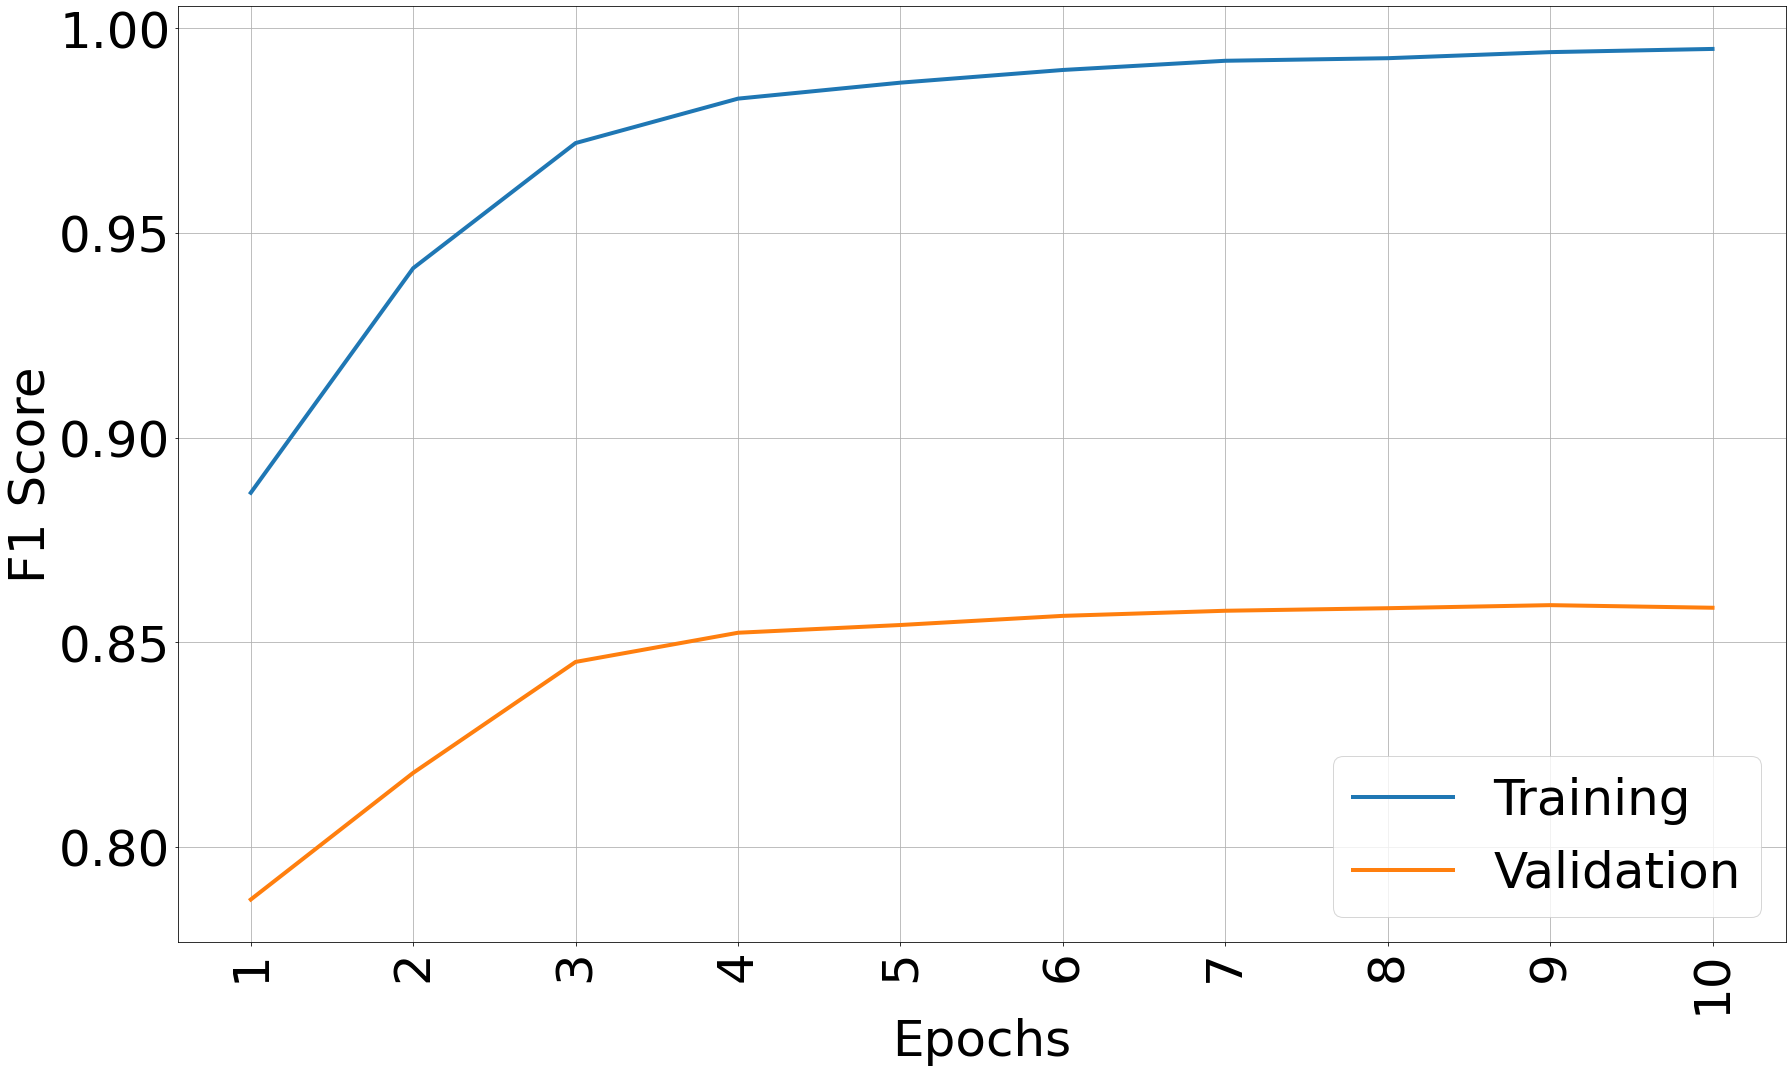

In [119]:
make_plot(train_f1_epochs, val_f1_epochs, 'F1 Score')

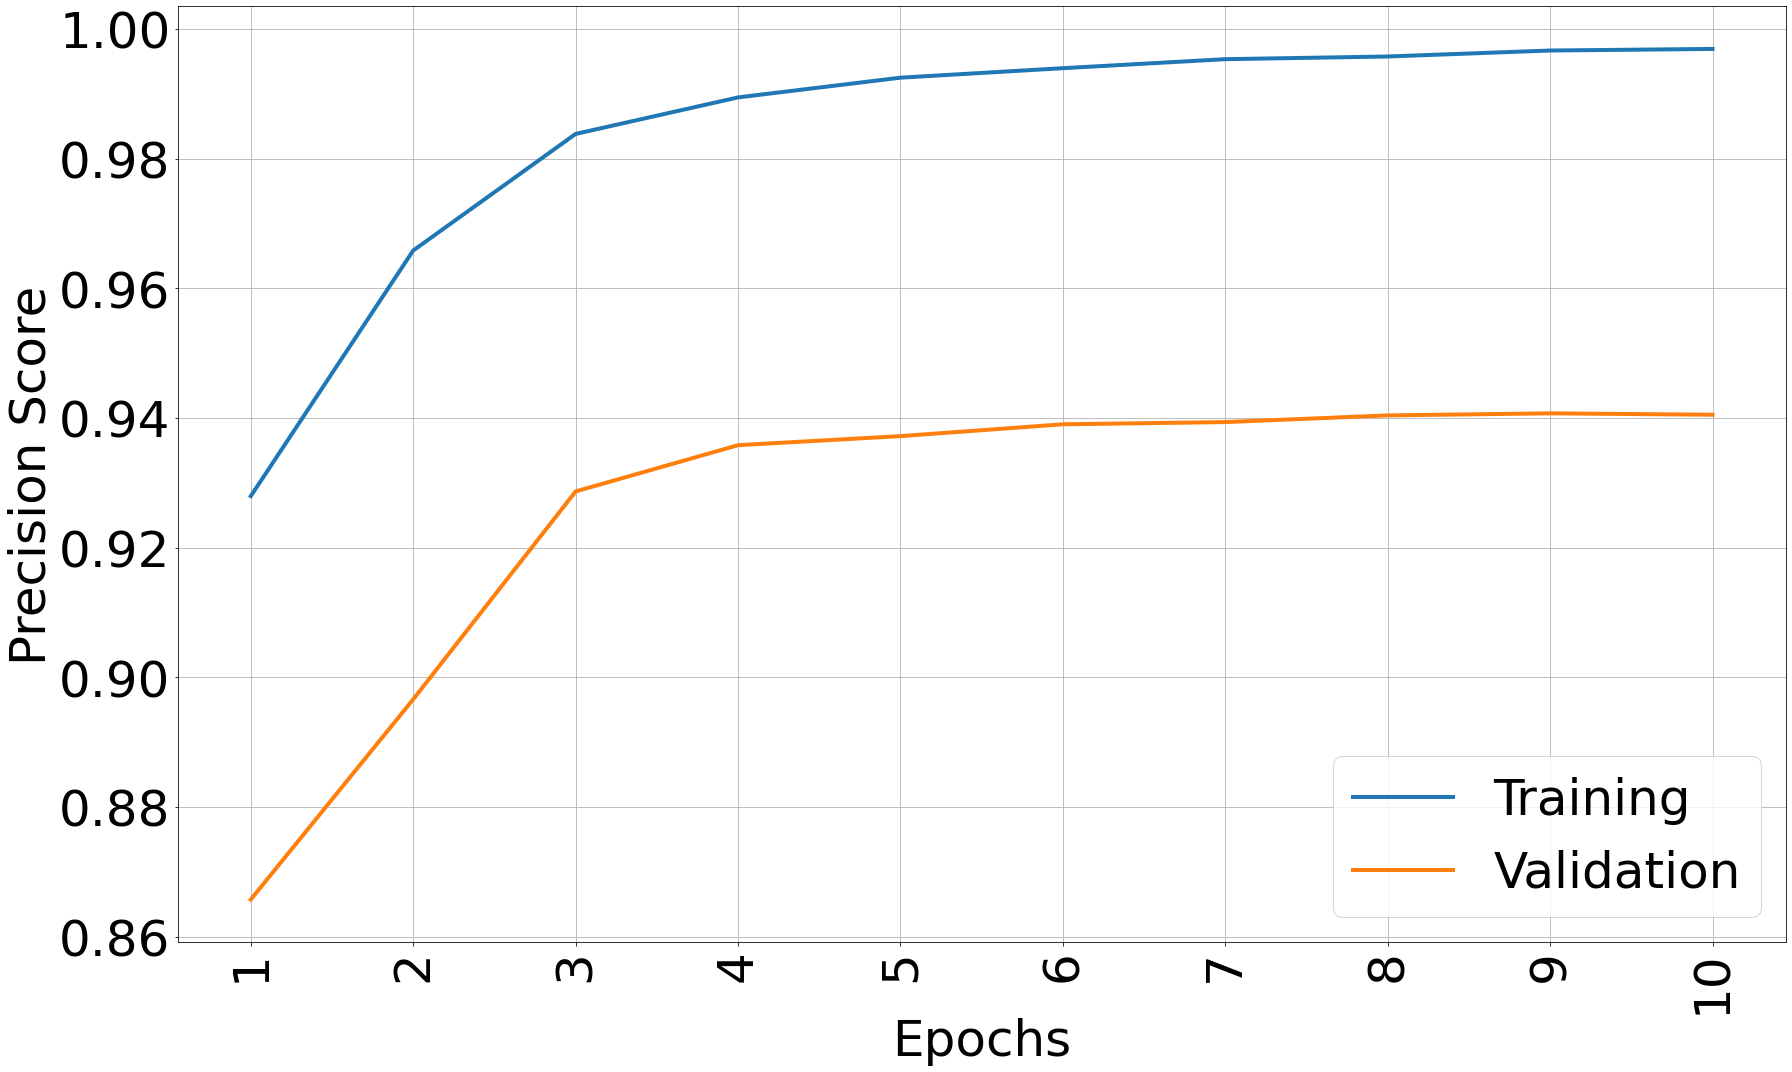

In [120]:
make_plot(train_precision_epochs, val_precision_epochs, 'Precision Score')

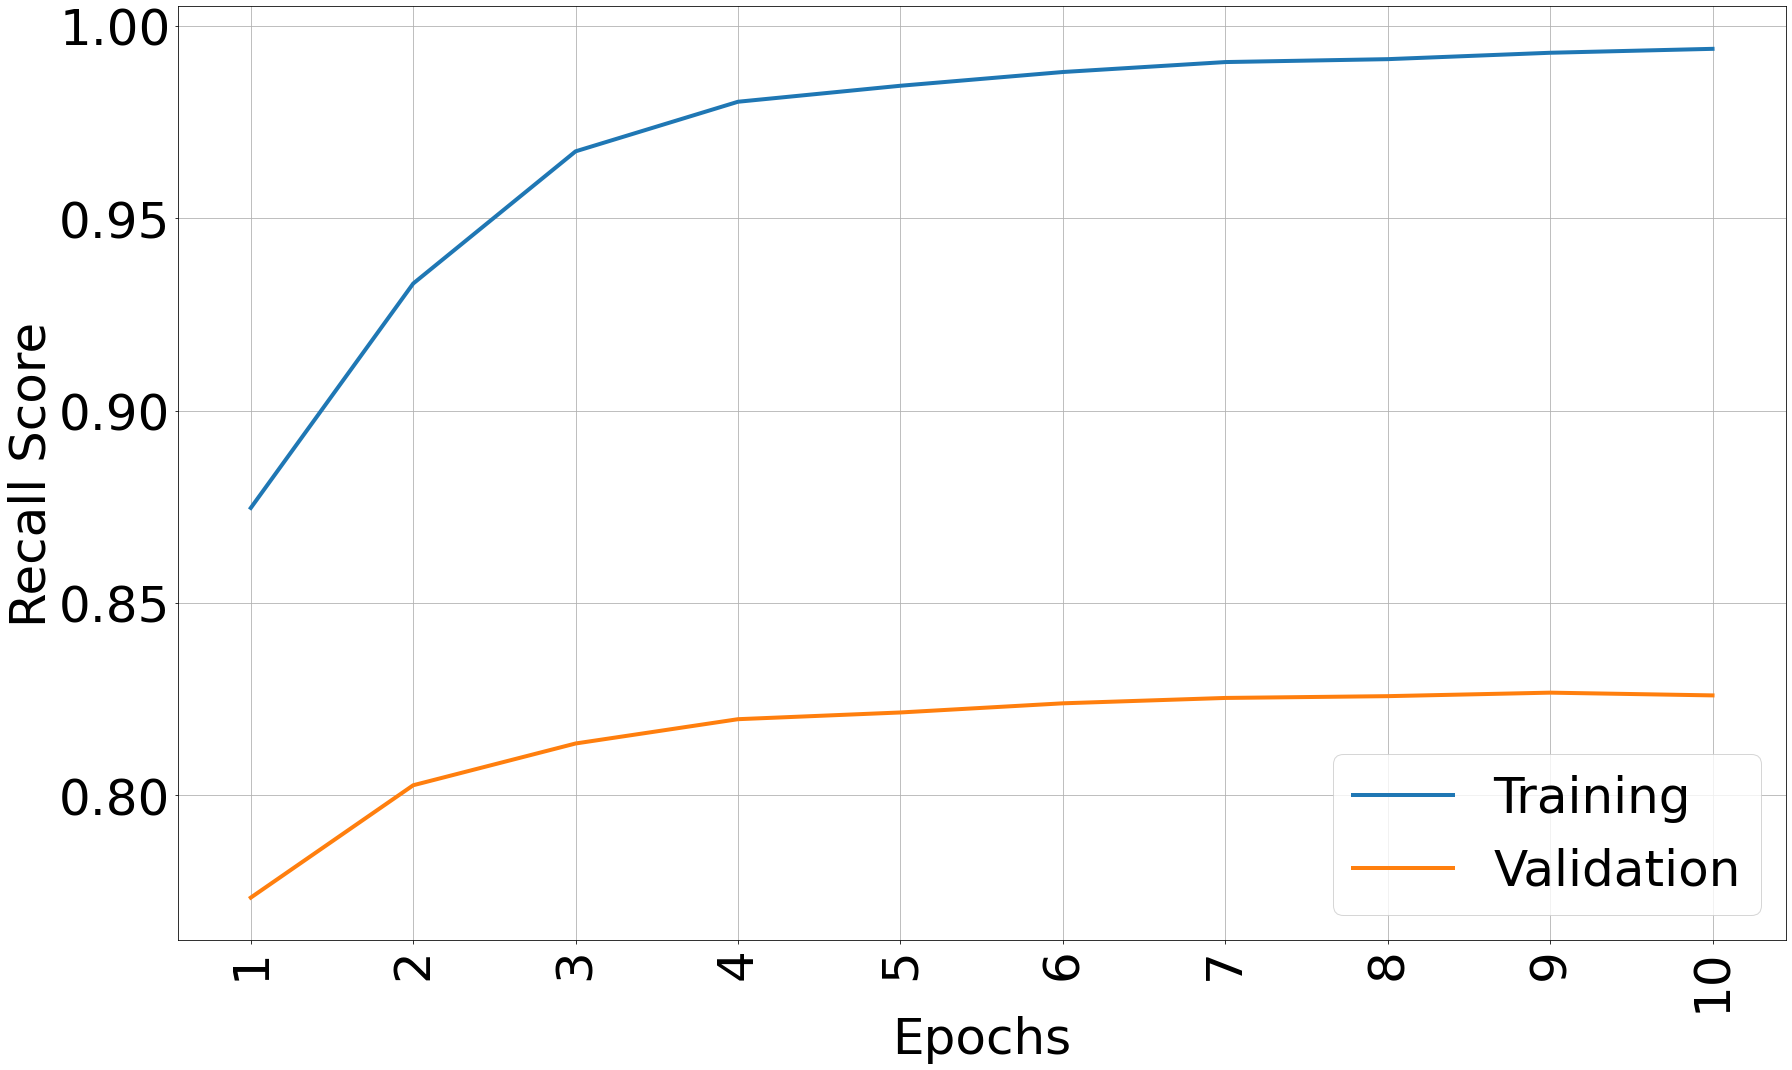

In [121]:
make_plot(train_recall_epochs, val_recall_epochs, 'Recall Score')

In [90]:
y_pred = np.argmax(lstm_model.predict(test_umls_text[400]), axis=-1)
print("{0:35} {1:15} {2:40} {3:40}".format('Extracted Entity', 'Code', 'Actual Label', 'Predicted Label'))
print("{0:35} {1:15} {2:40} {3:40}".format('________________', '____', '____________', '_______________'))
for x, x_code, yhat, y in zip(test_orgtext[400], test_umls_text[400], y_pred, test_labels[400]):
    if x != 0:
        #print('{0:>{numLength}}-{1:>{numLength}}: {2}'.format(lower[i], upper[i], '*' * num[i], numLength=digits))
        print("{0:35} {1:15} {2:40} {3:40}".format(x, inv_umls_text_map[x_code] ,inv_label_map[y], inv_label_map[yhat[0]]))

Extracted Entity                    Code            Actual Label                             Predicted Label                         
________________                    ____            ____________                             _______________                         
Genome-Wide Detection               c2350277        molecular biology research technique     molecular biology research technique    
of                                  of              o                                        o                                       
Selective Signatures                c0017393        genetic function                         genetic function                        
in                                  in              o                                        o                                       
Chicken                             c0008051        bird                                     bird                                    
through                             through         o         

In [70]:
f1_scores_no_O, f1_scores_with_O = [], []
y_pred = []

for x, y in zip(test_umls_text, test_labels):
    ypred = lstm_model.predict(x)
    ypred = np.argmax(ypred, axis=-1)
    y_pred.extend(ypred)
    f1_scores_no_O.append(exclude_from_f1(y, ypred, [0, 1]))
    f1_scores_with_O.append(exclude_from_f1(y, ypred, [0]))

print('f1 score on test data including "Other" tag', np.mean(f1_scores_with_O))
print('f1 score on test data without "Other" tag', np.mean(f1_scores_no_O))

f1 score on test data including "Other" tag 0.9357342074770839
f1 score on test data without "Other" tag 0.8594346171147316


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

## LSTM with UMLS customed Embedding

In [122]:
umls_embedding_file = "../input/umls-embeddings/embeddings.csv"

In [145]:
def concept_dict():
    umls_embeddings = pd.read_csv(umls_embedding_file, header=None)
    umls_embeddings_arr = np.array(umls_embeddings)
    dict_ = {} 
    for concept in umls_embeddings_arr:
        dict_[concept[0]] = concept[1:]
    
    del umls_embeddings
    del umls_embeddings_arr
    
    return dict_

concepts = concept_dict()

In [146]:
def get_embeddings():
    embed_size=50

    word_index = umls_text_tokenizer.word_index

    embedding_matrix = np.zeros((num_tokens_umls_text+1, embed_size))

    for word, i in word_index.items():
        embedding_vector = concepts.get(word.upper())
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    
    return embedding_matrix, embed_size

embedding_matrix, embed_size = get_embeddings()
del concepts

In [135]:
output_dim = 32
tf.random.set_seed(42)
opt = Adam(0.001)

sequence_input = Input(shape=(maxlen_umls_text,), dtype=tf.int32, name='sequence_input')
sequence_mask = Lambda(lambda x: tf.greater(x, 0))(sequence_input)
outputs = Embedding(input_dim=num_tokens_umls_text+1, output_dim=embed_size, weights=[embedding_matrix], trainable=True, mask_zero=True)(sequence_input)
outputs = Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat')(outputs)
outputs = (TimeDistributed(Dense(output_dim, activation="relu")))(outputs)

outputs = Dense(num_tags+1, activation="softmax")(outputs)

embed_model = Model(inputs=sequence_input, outputs=outputs)
embed_model.compile(loss = 'SparseCategoricalCrossentropy', optimizer=opt, metrics=['accuracy'])
embed_model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence_input (InputLayer)  [(None, 685)]             0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 685, 50)           3315900   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 685, 64)           21248     
_________________________________________________________________
time_distributed_7 (TimeDist (None, 685, 32)           2080      
_________________________________________________________________
dense_15 (Dense)             (None, 685, 128)          4224      
Total params: 3,343,452
Trainable params: 3,343,452
Non-trainable params: 0
_________________________________________________________________


In [136]:
train_f1_epochs, train_precision_epochs, train_recall_epochs = [], [], []
val_f1_epochs, val_precision_epochs, val_recall_epochs = [], [], []

for epoch in range(1, 11):
    print('epoch ', epoch)
    for x, y in zip(train_umls_text, train_labels):
        weights = get_weights(y)
        embed_model.train_on_batch(x, y, class_weight=weights)
    
    train_f1, train_precision, train_recall = [], [], []
    for x, y in zip(train_umls_text, train_labels):
        y_pred = np.argmax(embed_model.predict(x), axis=-1)
        train_f1.append(exclude_from_f1(y, y_pred, [0, 1]))
        train_precision.append(exclude_from_precision(y, y_pred, [0, 1]))
        train_recall.append(exclude_from_recall(y, y_pred, [0, 1]))
    
    train_f1_epochs.append(np.mean(train_f1))
    train_precision_epochs.append(np.mean(train_precision))
    train_recall_epochs.append(np.mean(train_recall))
    
    val_f1, val_precision, val_recall = [], [], []
    for x, y in zip(val_umls_text, val_labels):
        y_pred = np.argmax(embed_model.predict(x), axis=-1)
        val_f1.append(exclude_from_f1(y, y_pred, [0, 1]))
        val_precision.append(exclude_from_precision(y, y_pred, [0, 1]))
        val_recall.append(exclude_from_recall(y, y_pred, [0, 1]))
    
    val_f1_epochs.append(np.mean(val_f1))
    val_precision_epochs.append(np.mean(val_precision))
    val_recall_epochs.append(np.mean(val_recall))
    
    print(np.mean(val_f1), np.mean(val_precision), np.mean(val_recall))

epoch  1
0.7259930311601333 0.8005946209607832 0.7106534978507423
epoch  2
0.8070919478445201 0.8871417018091856 0.787920812139822
epoch  3
0.8355040908336678 0.9072682217578716 0.816866855758121
epoch  4
0.8542799038437767 0.9226990610882908 0.8350442197833439
epoch  5
0.8578482841576848 0.9384858809804724 0.8259093396017361
epoch  6
0.8603882890943779 0.9414189769014653 0.8282350797300265
epoch  7
0.8606361731715255 0.9418975263617135 0.8283355058290562
epoch  8
0.8612310994707959 0.9423041763186074 0.8290018808942374
epoch  9
0.8614231279189173 0.9423387455366748 0.829249473424998
epoch  10
0.8616788847237703 0.9429194968416013 0.8293982547512891


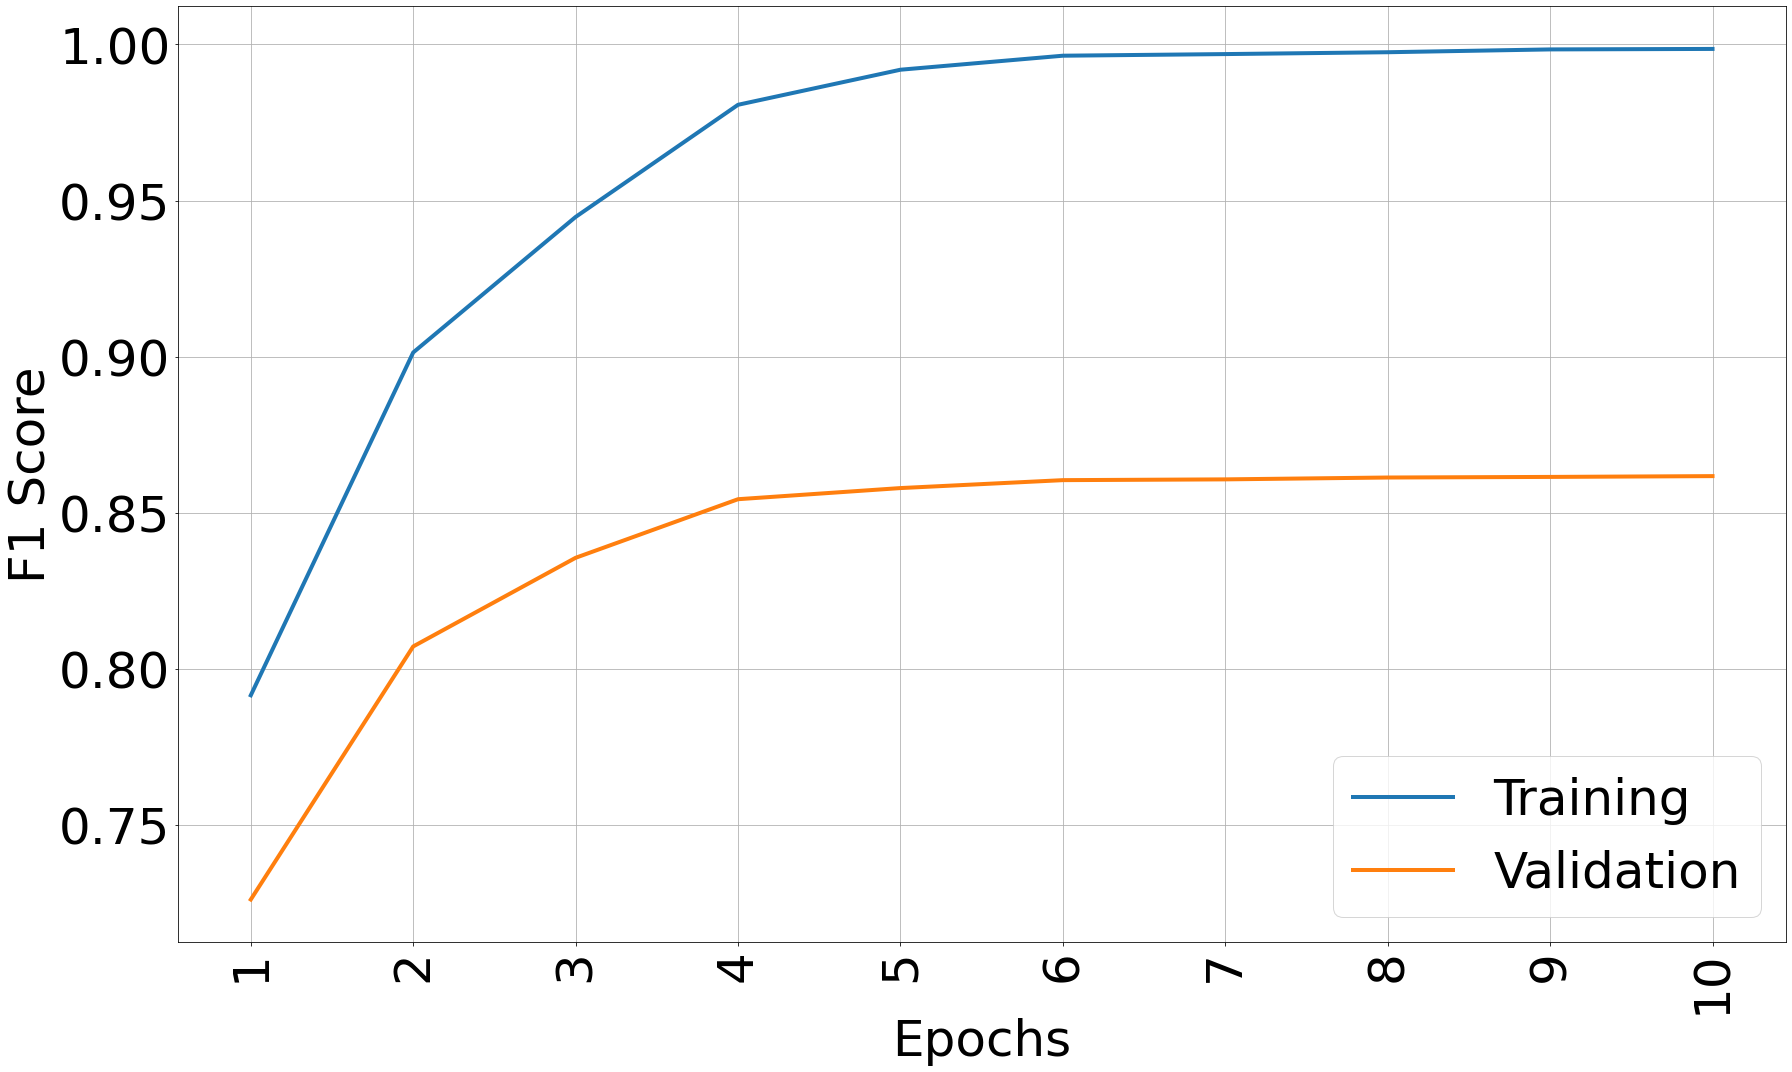

In [140]:
make_plot(train_f1_epochs, val_f1_epochs, 'F1 Score')

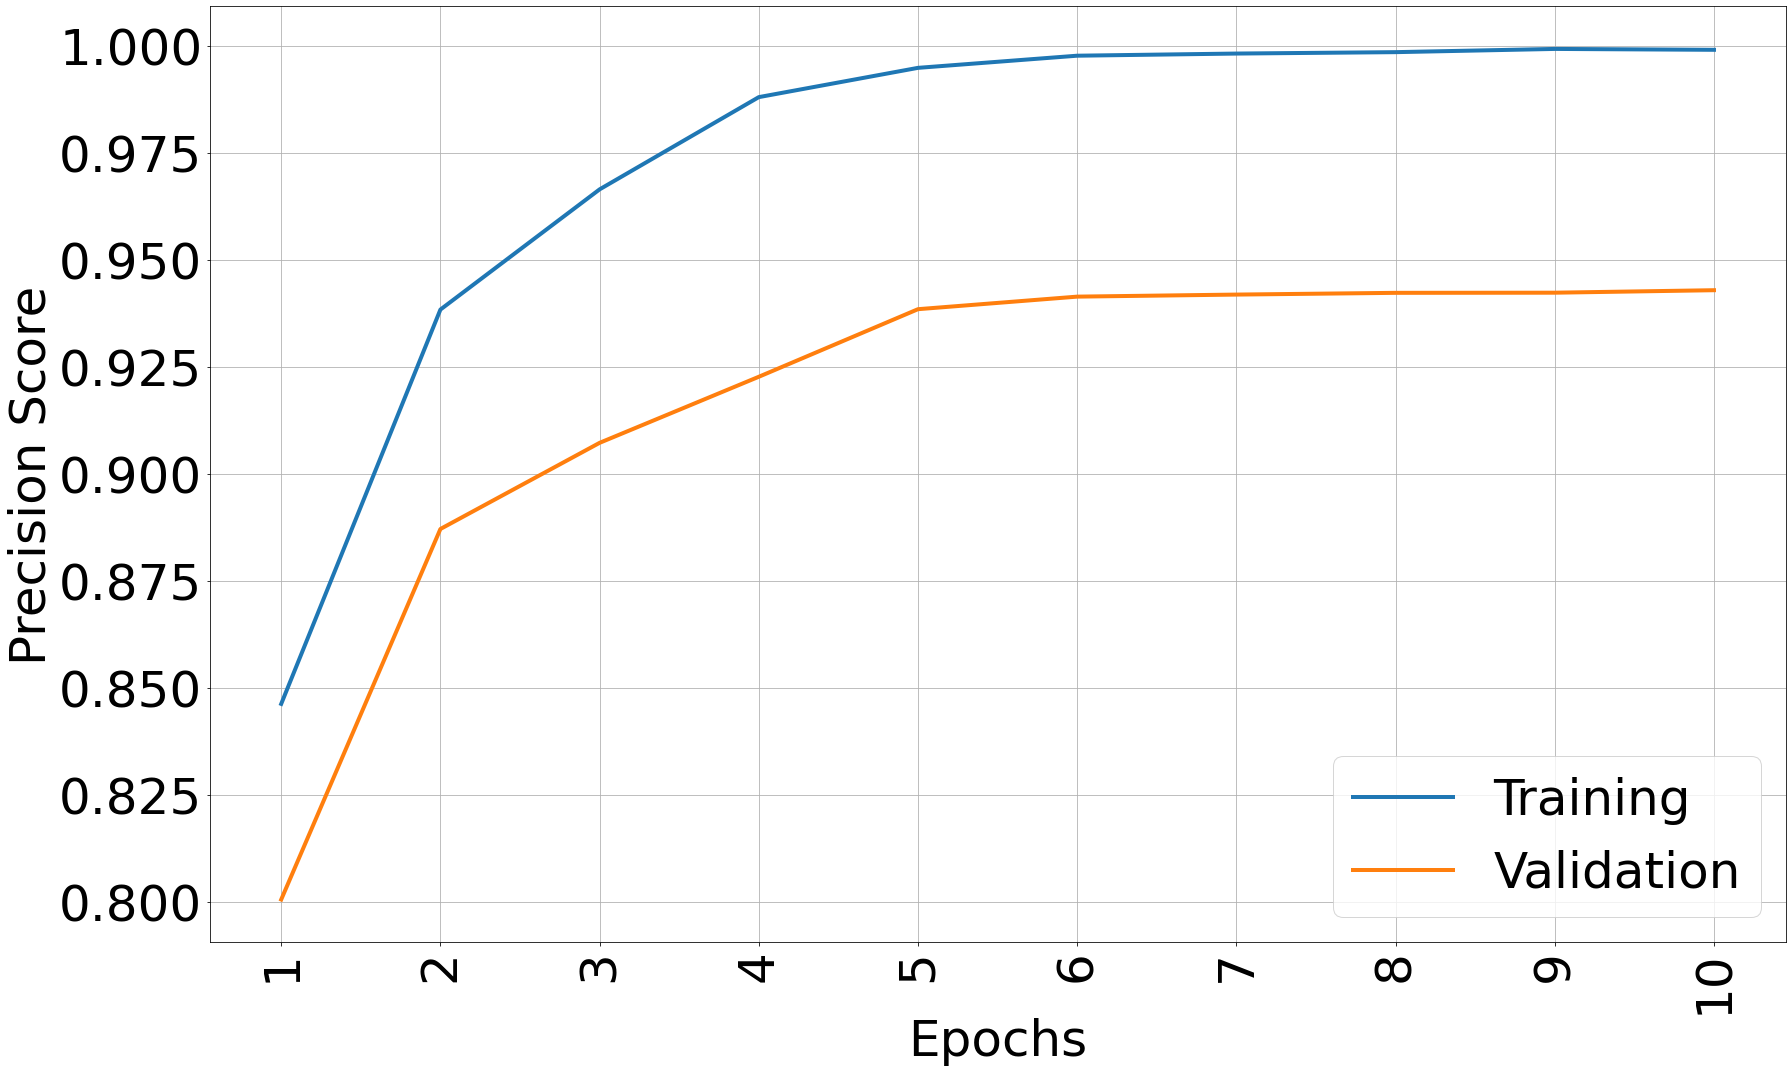

In [141]:
make_plot(train_precision_epochs, val_precision_epochs, 'Precision Score')

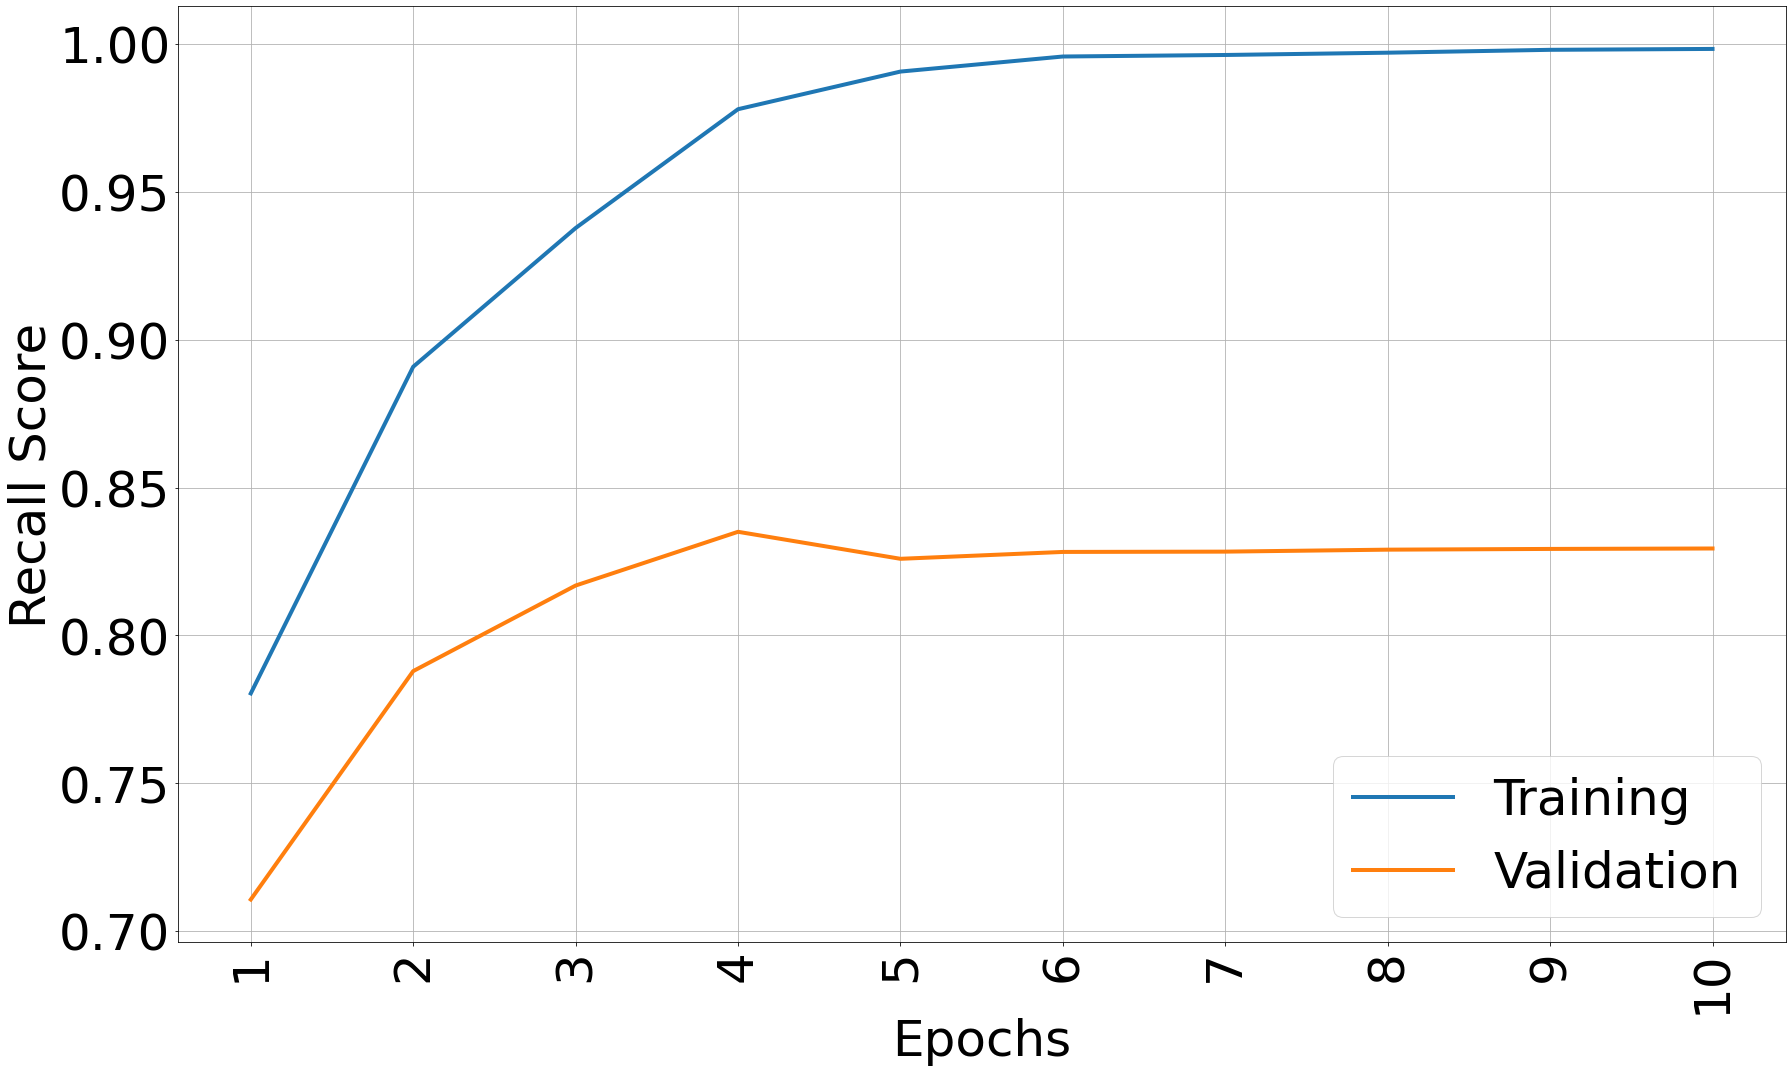

In [142]:
make_plot(train_recall_epochs, val_recall_epochs, 'Recall Score')

In [137]:
y_pred = np.argmax(embed_model.predict(test_umls_text[400]), axis=-1)
print("{0:35} {1:15} {2:40} {3:40}".format('Extracted Entity', 'Code', 'Actual Label', 'Predicted Label'))
print("{0:35} {1:15} {2:40} {3:40}".format('________________', '____', '____________', '_______________'))
for x, x_code, yhat, y in zip(test_orgtext[400], test_umls_text[400], y_pred, test_labels[400]):
    if x != 0:
        #print('{0:>{numLength}}-{1:>{numLength}}: {2}'.format(lower[i], upper[i], '*' * num[i], numLength=digits))
        print("{0:35} {1:15} {2:40} {3:40}".format(x, inv_umls_text_map[x_code] ,inv_label_map[y], inv_label_map[yhat[0]]))

Extracted Entity                    Code            Actual Label                             Predicted Label                         
________________                    ____            ____________                             _______________                         
Genome-Wide Detection               c2350277        molecular biology research technique     molecular biology research technique    
of                                  of              o                                        o                                       
Selective Signatures                c0017393        genetic function                         genetic function                        
in                                  in              o                                        o                                       
Chicken                             c0008051        bird                                     bird                                    
through                             through         o         

In [139]:
f1_scores_no_O, f1_scores_with_O = [], []
y_pred = []

for x, y in zip(test_umls_text, test_labels):
    ypred = embed_model.predict(x)
    ypred = np.argmax(ypred, axis=-1)
    y_pred.extend(ypred)
    f1_scores_no_O.append(exclude_from_f1(y, ypred, [0, 1]))
    f1_scores_with_O.append(exclude_from_f1(y, ypred, [0]))

print('f1 score on test data including "Other" tag', np.mean(f1_scores_with_O))
print('f1 score on test data without "Other" tag', np.mean(f1_scores_no_O))

f1 score on test data including "Other" tag 0.9367634087420813
f1 score on test data without "Other" tag 0.8618380733348496
